In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# read all the words
file_path = r'C:\Users\User\OneDrive\Desktop\all_in_one\build_makemore\names.txt'
words = open(file_path).read().splitlines()
words[-8:]

['zyell', 'zyheem', 'zykeem', 'zylas', 'zyran', 'zyrie', 'zyron', 'zzyzx']

In [3]:
# build the vocabulary of characters and mapping ro/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# utlity function to compare manuel gradient to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # the dimensionality of the character  embedding vector
n_hidden = 64 # the number of neurons in one hidden layer of MLP

g = torch.Generator().manual_seed(126372837)
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((vocab_size * n_embd)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm paramaters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1
bnbias = torch.randn((1, n_hidden)) * 0.1

# Note: I am initializating many of these parameters in non-standard ways because sometimes
# initializating with e.g. all zeros could mask an incorrect implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 64
n = batch_size # shorter variable also, for convenince
# minibatch
ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

In [8]:
#forwars pass, "chunkated" into smaller steps that are possible to backward one at a time
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
#Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm Layer
bnmeani = 1/n*hprebn.sum(0, keepdims=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * bndiff2.sum(0, keepdims=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logits_max = logits.max(1, keepdim=True).values
norm_logits = logits - logits_max
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum **-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = - logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logits_max, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3917, grad_fn=<NegBackward0>)

In [9]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logits_max)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw 

In [10]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()


# now
lost_fast = F.cross_entropy(logits,Yb)
print(lost_fast.item(), 'diff:', (lost_fast-loss).item())

3.391657829284668 diff: 2.384185791015625e-07


In [11]:
# backward pass
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 4.307366907596588e-09


In [12]:
logits.shape, Yb.shape

(torch.Size([64, 27]), torch.Size([64]))

In [13]:
F.softmax(logits, 1)[0]

tensor([0.0982, 0.0623, 0.0255, 0.0265, 0.0118, 0.0410, 0.0141, 0.0257, 0.0816,
        0.0150, 0.0441, 0.0391, 0.0189, 0.0307, 0.0433, 0.0452, 0.0195, 0.0146,
        0.0189, 0.0577, 0.0134, 0.0221, 0.0379, 0.0914, 0.0203, 0.0450, 0.0361],
       grad_fn=<SelectBackward0>)

In [14]:
dlogits[0] * n

tensor([ 0.0982,  0.0623,  0.0255,  0.0265,  0.0118,  0.0410,  0.0141,  0.0257,
         0.0816,  0.0150,  0.0441,  0.0391, -0.9811,  0.0307,  0.0433,  0.0452,
         0.0195,  0.0146,  0.0189,  0.0577,  0.0134,  0.0221,  0.0379,  0.0914,
         0.0203,  0.0450,  0.0361], grad_fn=<MulBackward0>)

In [15]:
dlogits[0].sum()

tensor(-6.9849e-10, grad_fn=<SumBackward0>)

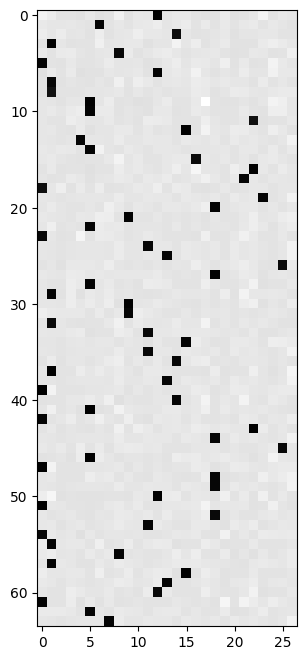

In [16]:
plt.figure(figsize=(4, 8))
plt.imshow(dlogits.detach(), cmap='gray');

In [17]:
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [18]:
# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


In [19]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([64, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([64, 64]),
 torch.Size([64]))

In [20]:
# putting all together

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(123432482)
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.1 + 1
b2 = torch.randn(vocab_size, generator=g) * 0.1
#BatchNorm
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bnbias, bngain]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 300000
batch_size = 64
n = batch_size
lossi = []

with torch.no_grad():

    for i in range(max_steps):

        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward pass
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)
        # Linear layer
        hprebn = embcat @ W1 + b1
        # BatchNorm Layer
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True)
        bnvar_inv = (bnvar + 1e-5) **-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # Non-Linearity
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Yb) # loss function

        #backward pass
        for p in parameters:
            p.grad = None
        #loss.backward() # we do not this anymore

        # manual backprop!
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -=1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1.0 - h**2) * dh
        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        #update
        lr = 0.1 if i < 250000 else 0.05 if i < 300000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

12297
      0/ 300000: 3.7574
  10000/ 300000: 2.1278
  20000/ 300000: 2.2110
  30000/ 300000: 2.3805
  40000/ 300000: 2.3481
  50000/ 300000: 2.5489
  60000/ 300000: 2.5013
  70000/ 300000: 2.4206
  80000/ 300000: 2.0369
  90000/ 300000: 2.5524
 100000/ 300000: 2.3851
 110000/ 300000: 2.2343
 120000/ 300000: 2.4637
 130000/ 300000: 2.2598
 140000/ 300000: 2.3715
 150000/ 300000: 2.2726
 160000/ 300000: 2.4450
 170000/ 300000: 2.2943
 180000/ 300000: 2.2774
 190000/ 300000: 2.4593
 200000/ 300000: 2.5401
 210000/ 300000: 2.1008
 220000/ 300000: 2.3615
 230000/ 300000: 2.0875
 240000/ 300000: 2.3693
 250000/ 300000: 2.4875
 260000/ 300000: 2.2724
 270000/ 300000: 2.2527
 280000/ 300000: 2.2696
 290000/ 300000: 2.3104


In [21]:
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2336275577545166
val 2.2382757663726807


In [23]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

eria.
kayah.
seen.
ndhayah.
rethrshendraeg.
adered.
eliigh.
porea.
eden.
estanar.
kateivelka.
cayshabergahirie.
tan.
jowellionno.
adriu.
zayven.
jamell.
ehs.
kaysh.
sanyan.
